In [1]:
import gc
import multiprocessing
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

In [2]:
df = pd.read_csv("../curated-data/CorrelationData_conf_SR2.csv")
df.head(5)

,Rank,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,...,NCP,CR,SR,ACP,AR,DWH,DWR,DDR,T,DS
0,3,24,38,2,8,10,3,8,16,17,...,2,2,1,1,3,3,50,90,2,1
1,2,17,35,6,9,7,4,8,25,14,...,1,3,1,1,1,1,30,30,3,1
2,1,20,38,8,8,6,5,7,19,22,...,1,3,1,1,2,1,90,90,4,1
3,3,18,28,6,4,10,3,8,13,12,...,3,3,1,2,3,1,50,50,5,1
4,2,23,56,6,9,10,8,5,18,34,...,1,3,1,3,3,1,50,30,4,1


In [3]:
# from scipy.stats import boxcox
# df['NASA'], lmbda = boxcox(df['NASA'], lmbda=None)
# df['TA'], lmbda = boxcox(df['TA'], lmbda=None)
# df['EXT'], lmbda = boxcox(df['EXT'], lmbda=None)

# df['CS'], lmbda = boxcox(df['CS'], lmbda=None)
# df['NT'], lmbda = boxcox(df['NT'], lmbda=None)
# df['OP'], lmbda = boxcox(df['OP'], lmbda=None)
# df['Task'], lmbda = boxcox(df['Task'], lmbda=None)
# df['TWR'], lmbda = boxcox(df['TWR'], lmbda=None)
# df['DDR'], lmbda = boxcox(df['DDR'], lmbda=None)

<AxesSubplot:>

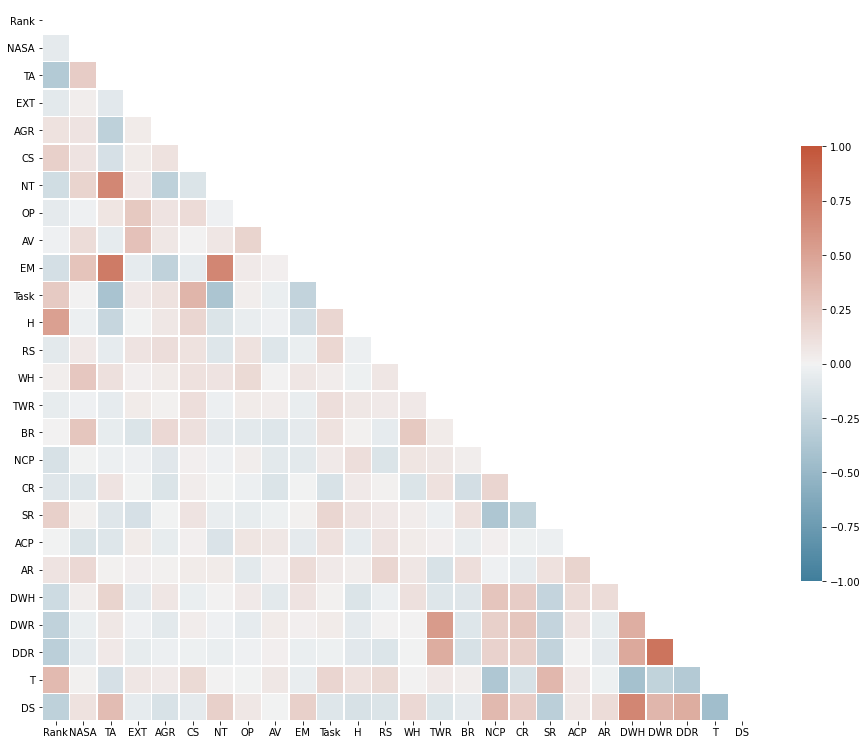

In [4]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['SR']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [6]:
# print('Distributions of all columns')
# plt.figure(figsize=(30, 30))
# for i, col in enumerate(list(X_train.columns)[0:23]):
#     plt.subplot(8, 3, i + 1)
# #     if X_train[col].dtype == np.
#     sns.distplot(X_train[col], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
#     plt.xlabel(X_train.columns[i], fontsize=14, fontweight='bold')

In [7]:
%%time
rf = RandomForestClassifier(n_estimators = 2000, max_features = 'auto', bootstrap = True)
rf.fit(X_train, Y_train)

Wall time: 2.17 s


RandomForestClassifier(n_estimators=2000)

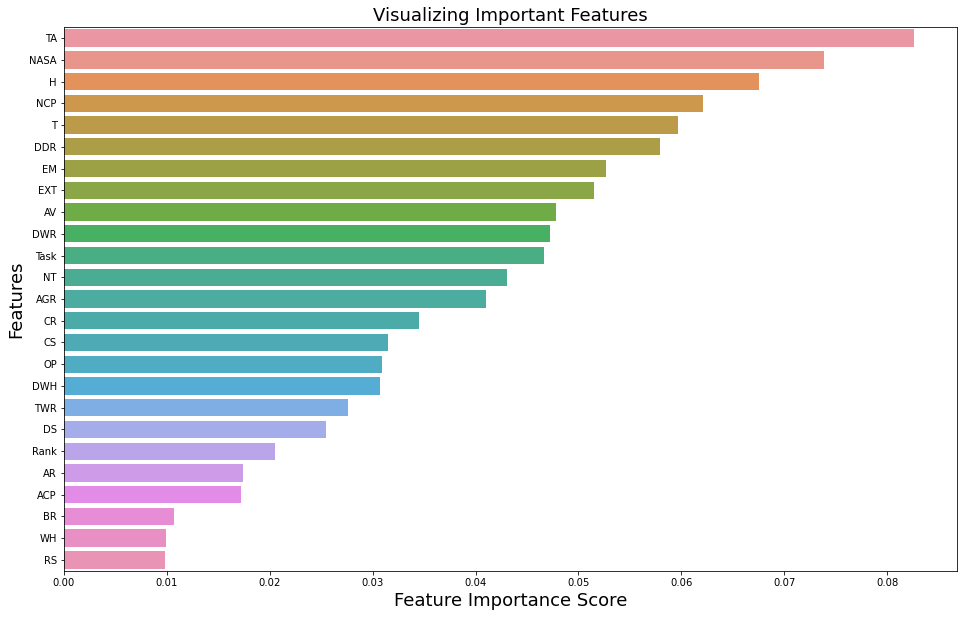

In [8]:
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()

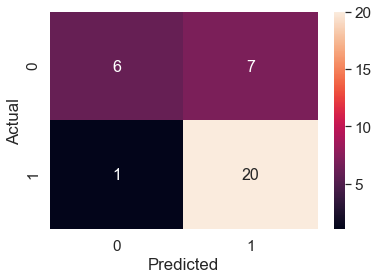

In [9]:
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
plot = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}) # font size
plot.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [10]:
# !pip install plotly
# import plotly.express as px

# # df = px.data.medals_wide(indexed=True)
# fig = px.imshow(conf_mat)
# fig.show()

In [11]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.7647058823529411
Precision:  0.7407407407407407
Recall:  0.9523809523809523
F1:  0.8333333333333334
Auc Score:  0.8205128205128205


In [12]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
TA,0.082610
NASA,0.073865
H,0.067568
NCP,0.062106
T,0.059649
DDR,0.057934
EM,0.052714
EXT,0.051514
AV,0.047864
DWR,0.047196


In [13]:
df_features = df[['NCP', 'TA', 'T', 'H', 'EXT', 'NASA', 'Task', 'EM', 'AV', 'DWR', 'NT', 'AGR', 'OP', 'TWR', 'SR']].copy()
df_features

,NCP,TA,T,H,EXT,NASA,Task,EM,AV,DWR,NT,AGR,OP,TWR,SR
0,2,38,2,41,2,24,26,17,16,50,3,8,8,30,1
1,1,35,3,25,6,17,31,14,25,30,4,9,8,30,1
2,1,38,4,0,8,20,29,22,19,90,5,8,7,90,1
3,3,28,5,60,6,18,35,12,13,50,3,4,8,50,1
4,1,56,4,16,6,23,27,34,18,50,8,9,5,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,3,25,3,87,9,17,28,10,23,70,3,9,8,50,0
166,2,36,4,10,5,21,30,15,17,60,3,10,7,50,1
167,3,48,1,26,8,30,22,20,7,80,5,10,7,70,1
168,3,34,1,25,6,13,27,10,16,80,3,7,10,40,0


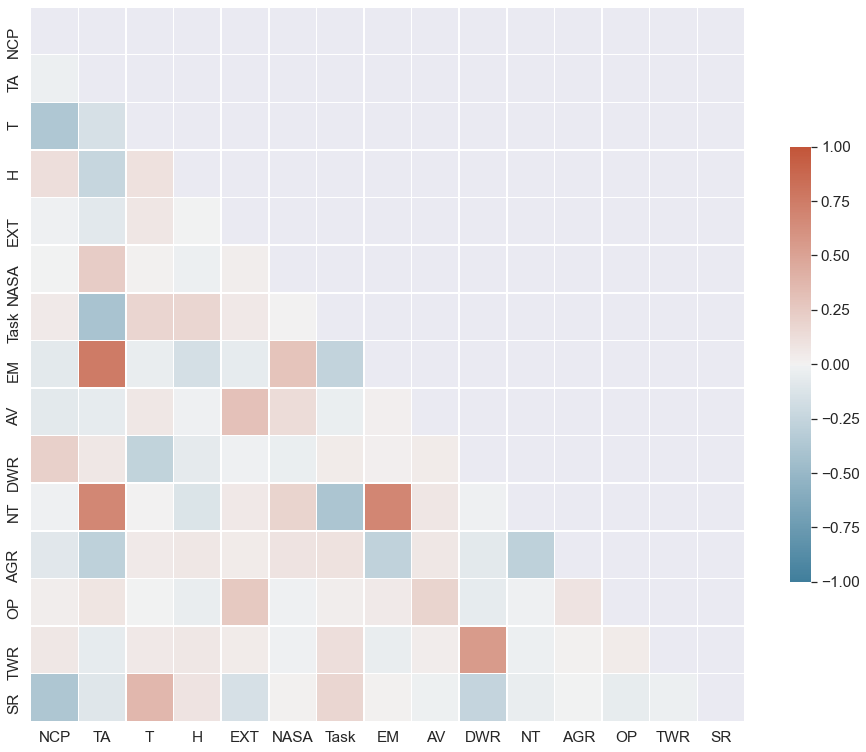

In [14]:
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [15]:
df_features = df[['NCP', 'TA', 'T', 'H', 'EXT', 'NASA', 'Task', 'AV', 'DWR', 'AGR', 'OP', 'TWR', 'SR']].copy()
df_features

,NCP,TA,T,H,EXT,NASA,Task,AV,DWR,AGR,OP,TWR,SR
0,2,38,2,41,2,24,26,16,50,8,8,30,1
1,1,35,3,25,6,17,31,25,30,9,8,30,1
2,1,38,4,0,8,20,29,19,90,8,7,90,1
3,3,28,5,60,6,18,35,13,50,4,8,50,1
4,1,56,4,16,6,23,27,18,50,9,5,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,3,25,3,87,9,17,28,23,70,9,8,50,0
166,2,36,4,10,5,21,30,17,60,10,7,50,1
167,3,48,1,26,8,30,22,7,80,10,7,70,1
168,3,34,1,25,6,13,27,16,80,7,10,40,0


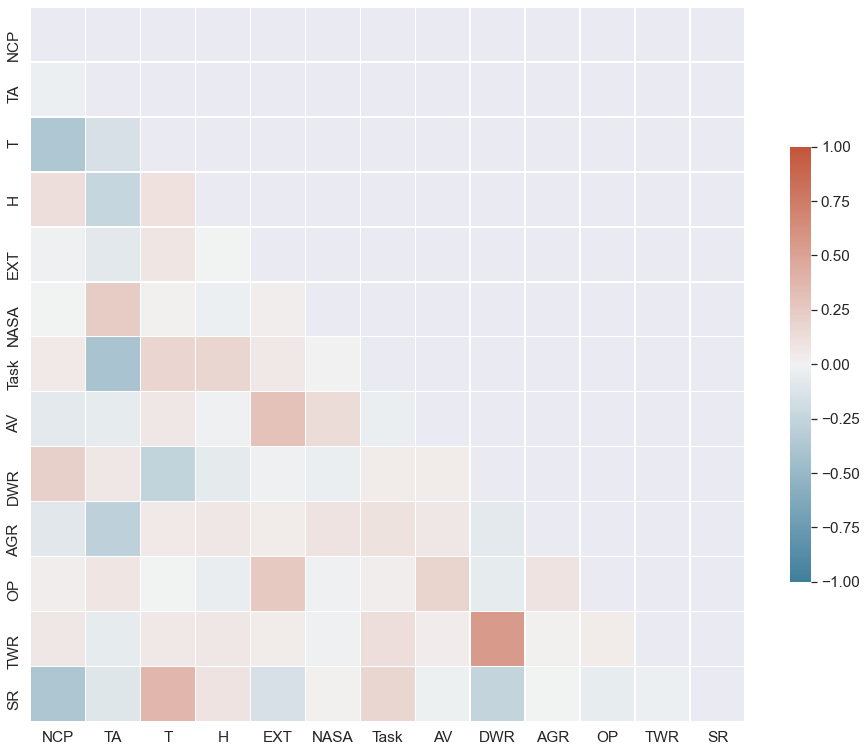

In [16]:
import seaborn as sns
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_features, df_features['SR']):
    strat_train_set = df_features.loc[train_index]
    strat_test_set = df_features.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [18]:
%%time
rf = RandomForestClassifier(n_estimators = 2000, max_features = 'auto', bootstrap = True)
rf.fit(X_train, Y_train)

Wall time: 2.16 s


RandomForestClassifier(n_estimators=2000)

In [19]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
TA,0.131162
NASA,0.116931
H,0.098013
T,0.090318
DWR,0.085410
NCP,0.085353
EXT,0.078463
AV,0.078387
Task,0.077187
AGR,0.059676


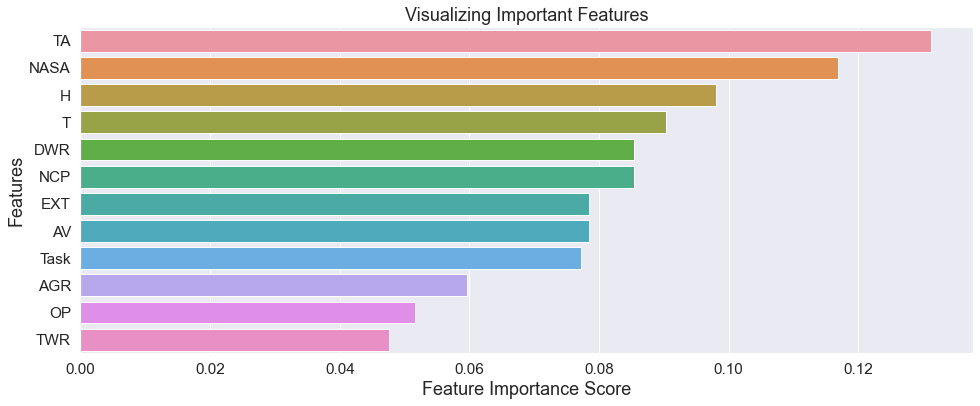

In [20]:
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()

In [21]:
# df_buffered = df[['NCP', 'EXT', 'Task', 'CR', 'H', 'DDR', 'T', 'DS', 'SR']].copy()
# df_buffered = df[['NCP', 'TA', 'T', 'H', 'EXT', 'Task', 'AV', 'DDR', 'CR',  'DS', 'SR']].copy()

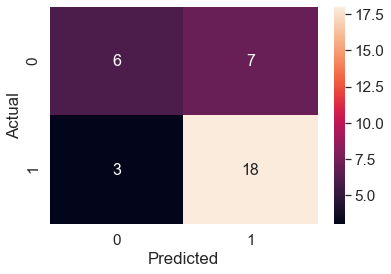

In [22]:
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
plot = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}) # font size
plot.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [23]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.7058823529411765
Precision:  0.72
Recall:  0.8571428571428571
F1:  0.782608695652174
Auc Score:  0.8315018315018314


In [24]:
df_buffered = df[['NCP', 'EXT', 'Task', 'CR', 'H', 'DWR', 'T', 'DS', 'SR']].copy()
df_buffered

,NCP,EXT,Task,CR,H,DWR,T,DS,SR
0,2,2,26,2,41,50,2,1,1
1,1,6,31,3,25,30,3,1,1
2,1,8,29,3,0,90,4,1,1
3,3,6,35,3,60,50,5,1,1
4,1,6,27,3,16,50,4,1,1
...,...,...,...,...,...,...,...,...,...
165,3,9,28,3,87,70,3,1,0
166,2,5,30,2,10,60,4,1,1
167,3,8,22,3,26,80,1,1,1
168,3,6,27,3,25,80,1,3,0


<AxesSubplot:>

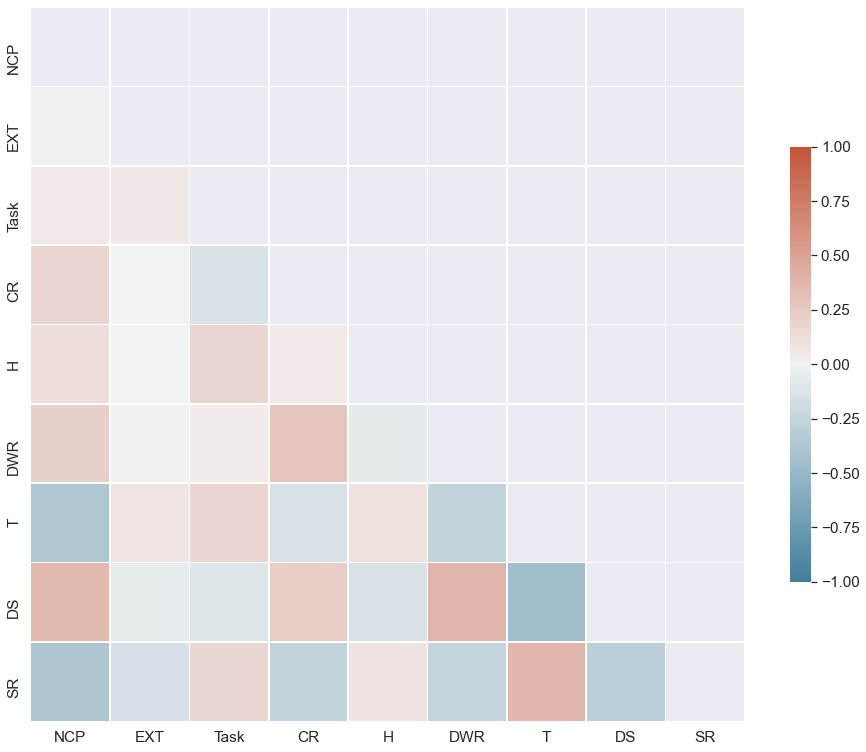

In [25]:
corr = df_buffered.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_buffered, df_buffered['SR']):
    strat_train_set = df_buffered.loc[train_index]
    strat_test_set = df_buffered.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [27]:
rf = RandomForestClassifier(n_estimators = 2000,
                                   max_features = 'auto',
                                   bootstrap = True)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=2000)

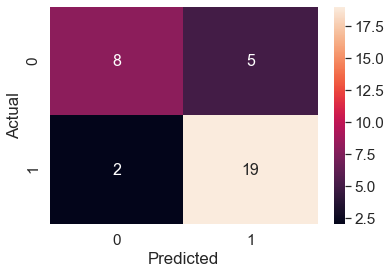

In [28]:
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
plot = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}) # font size
plot.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [29]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.7941176470588235
Precision:  0.7916666666666666
Recall:  0.9047619047619048
F1:  0.8444444444444444
Auc Score:  0.9377289377289377


In [30]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
# df_feature_importance

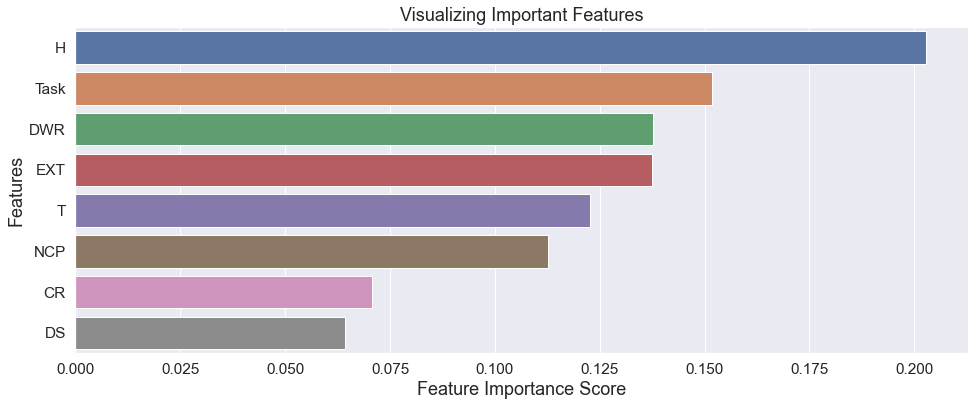

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
# df_feature_importance
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()

In [32]:
df_final = df[['NCP', 'TA', 'CR', 'EXT', 'Task', 'NASA', 'H', 'DWR', 'T', 'AV', 'AGR', 'OP', 'DS', 'SR']].copy()

<AxesSubplot:>

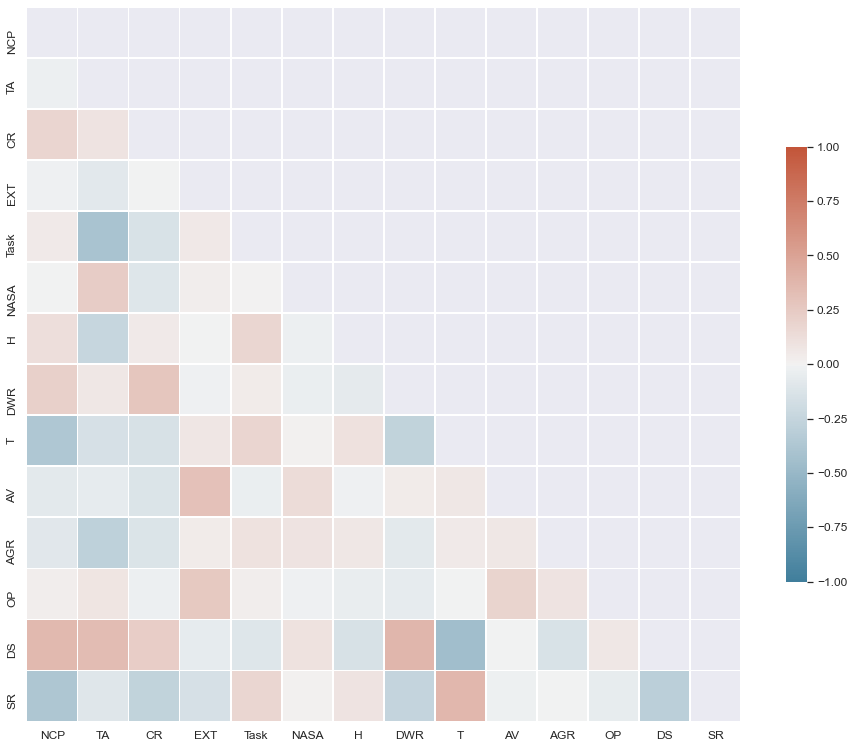

In [33]:
corr = df_final.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [34]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_final, df_final['SR']):
    strat_train_set = df_final.loc[train_index]
    strat_test_set = df_final.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [35]:
rf = RandomForestClassifier(n_estimators = 1600,
                                   max_features = 'auto',
                                   bootstrap = True)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)

conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
confusion_matrix(Y_test, y_pred)

array([[ 6,  7],
       [ 1, 20]], dtype=int64)

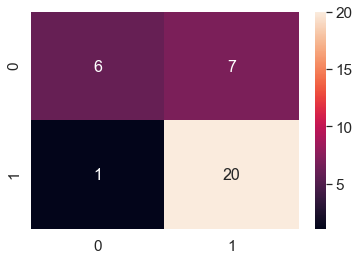

In [36]:
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [37]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.7647058823529411
Precision:  0.7407407407407407
Recall:  0.9523809523809523
F1:  0.8333333333333334
Auc Score:  0.8644688644688645


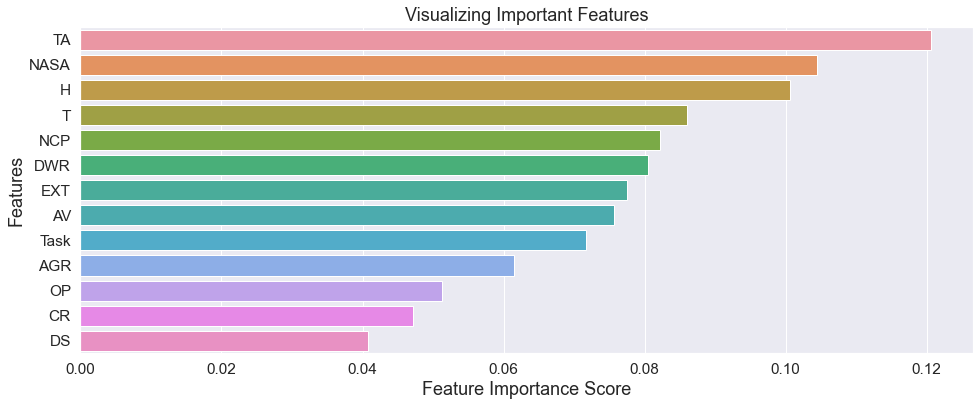

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
# df_feature_importance
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()